# Implementing ARIMA Model

***

This code implements an ARIMA model using the `auto_arima` function from the `pmdarima` python module. See [documentation](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima) here.

We manually determine the following parameters to save computation time:

* `d`: the order of first differencing determined by the Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test of stationarity - returns the maximum value of `d` such that the time series is judged as stationary.
* `D`: the order of seasonal differencing determined by the Osborn, Chui, Smith, and Birchenhall (OCSB) test - returns the maximum value of `D` such that the time series is judged seasonally stationary.

The `auto_arima` function determines the optimal order for the ARIMA model:

* `p`: the number of time lags for the AR model
* `q`: the order of the moving-average model
* `P`: the order of the auto-regressive portion of seasonal model
* `Q`: the order of moving-average portion of seasonal model

The resulting model is parameterized as `ARIMA(p, d, q)(P, D, Q, m)`, where `m` is the frequency (number of observations) in a seasonal cycle.

***

## Steps

The substeps in **Step 1** should reflect modeling steps from [Forecasting: Principles and Practice](https://otexts.com/fpp2/arima-r.html). Need to add box-cox transformation after **1.1** and Portmenteau test of residual autocorrelation in **1.6**.

* **Step 1**: Apply ARIMA model to one series.
    - **1.1** Plot data.
    - **1.2** Examine autocorrelation.
    - **1.3** Calculate `d` and `D`.
    - **1.4** Fit the model.
    - **1.5** Model Summary.
    - **1.6** Check residual autocorrelation.
    - **1.7** Make and evaluate forecasts using `RMSE` and `MAE`.
* **Step 2**: Apply ARIMA models to all series, make and evaluate forecasts.

In [1]:
# load modules
import pmdarima as pm
import statsmodels.tools.eval_measures as em
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import weekly finance series, skipping column names
ts = np.genfromtxt("../../../Data/Train/Clean/weekly_finance_clean.csv", delimiter = ',', skip_header = 1)

**Note**: we currently only select 10 series for the remainder of the code since `auto_arima` takes a long time to fit.

In [3]:
# select a subset of series - auto_arima takes a long time to fit
ts = ts[100:103,:]

In [4]:
# store the total number of series and the number of time periods
num_series, num_t = ts.shape

In [7]:
for i, x in enumerate(ts):
    print(i)
    print(x)

0
[1448.257  1444.8683 1453.8068 1435.1043 1454.8812 1446.8177 1460.7048
 1447.4605 1454.129  1475.8891 1470.5369 1469.134  1456.6336 1494.2964
 1473.3608 1473.1794 1460.5507 1478.7043 1476.2993 1476.5804 1473.1792
 1472.4674 1513.0613 1491.6274 1484.4418 1475.9986 1503.0601 1489.2202
 1515.6916 1484.1354 1487.667  1514.5741 1528.2804 1513.2458 1530.3425
 1540.333  1533.8862 1548.6939 1559.4259 1598.1255 1563.3389 1564.8509
 1554.6806 1532.545  1553.2236 1542.4581 1560.6627 1539.3411 1566.1371
 1553.7368 1548.311  1543.0557 1574.2014 1567.2749 1584.7633 1571.3282
 1580.7939 1579.3112 1578.3872 1572.7384 1584.7298 1591.0142 1579.1816
 1578.8678 1569.2447 1606.7826 1595.3    1600.9953 1583.8949 1595.805
 1607.6782 1604.8128 1608.4684 1609.8541 1650.3328 1632.194  1632.2757
 1618.4236 1646.0968 1636.1931 1663.8615 1630.7862 1624.6436 1652.7401
 1667.1439 1648.1414 1660.765  1672.3558 1660.4782 1678.741  1698.3769
 1747.7678 1715.4913 1696.6062 1697.6409 1680.8603 1697.6467 1680.4936
 1697

***

## Step 1
Apply ARIMA modeling process to one series.

#### 1.1 Plot the data

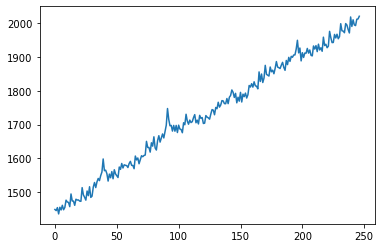

In [5]:
# plot a random series we will use for model testing
x = ts[0,:]
plt.plot(x)
plt.show()

#### 1.2 Examine autocorrelation.

c:\users\cameron\appdata\local\programs\python\python38\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  res = tsaplots.plot_acf(


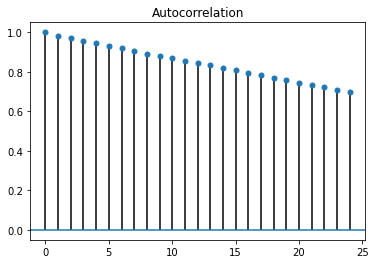

In [6]:
# autocorrelation plot
pm.plot_acf(x)

Highly auto-correlated series.

#### 1.3 Calculate `d` and `D`.

In [7]:
train, test = x[:-20], x[-20:]

[Seasonality blog post by Rob Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).

Doing this manually saves some computation time, [documentation here](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html#pmdarima.arima.ndiffs). Used to pre-determine the number of differences to take `d`.

In [8]:
# kpss test of stationarity
d = pm.arima.ndiffs(train, alpha = 0.05, test = 'kpss', max_d = 2)
d

1

#### 2.2. Conduct OCSB Test of Seasonality

Again, doing this manually saves some computation time, [documentation here](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.OCSBTest.html#pmdarima.arima.OCSBTest.estimate_seasonal_differencing_term). Used to pre-determine the number of seasonal differences to take `D`.

In [9]:
# conduct OCSB test of seasonality
m = 52 # 52 weeks in a year, recommended by Hyndman
D = pm.arima.nsdiffs(train, m)
D

0

#### 1.4 Fit the model.

The stepwise approach follows the strategy laid out by Hyndman and Khandakar in their 2008 paper, “Automatic Time Series Forecasting: The forecast Package for R”.

In [10]:
# fit stepwise auto-ARIMA
stepwise_fit = pm.auto_arima(train, 
                             m=52,                   # seasonal differencing term                
                             seasonal=True,          # compute seasonal model
                             d=d,                    # pre-calculated number of differences
                             D=D,                    # pre-calculated number of seasonal differences
                             trace=True,             # print optimization process results
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True, # don't want convergence warnings
                             stepwise=True)          # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=1734.536, Time=8.72 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1947.358, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=2.76 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1949.083, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=inf, Time=5.06 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=1732.487, Time=7.96 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=1861.166, Time=0.27 sec
 ARIMA(2,1,2)(2,0,0)[52] intercept   : AIC=inf, Time=31.85 sec
 ARIMA(2,1,2)(2,0,1)[52] intercept   : AIC=inf, Time=48.97 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept   : AIC=1732.161, Time=4.85 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=1867.751, Time=0.16 sec
 ARIMA(1,1,2)(2,0,0)[52] intercept   : AIC=1733.873, Time=26.97 sec
 ARIMA(1,1,2)(1,0,1)[52] intercept   : AIC=1733.878, Time=4.48 sec
 ARIMA(1,1,2)(0,0,1)[52] intercept   : AI

#### 1.5 Model Summary.

In [11]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  227
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 52)   Log Likelihood                -860.127
Date:                             Thu, 10 Feb 2022   AIC                           1728.254
Time:                                     13:13:58   BIC                           1741.936
Sample:                                          0   HQIC                          1733.776
                                             - 227                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5542      0.214      2.591      0.010       0.135       0.973
ma.L1         -0.5983      0.054    -10.998      0.000      -0.705      -0.492
ar.S.L52       0.7495      0.031     24.180      0.000       0.689       0.810
sigma2        97.7450      7.478     13.072      0.000      83.089     112.401
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):                37.72
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                             0.69
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 1.6 Check residual autocorrelation.

c:\users\cameron\appdata\local\programs\python\python38\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  res = tsaplots.plot_acf(


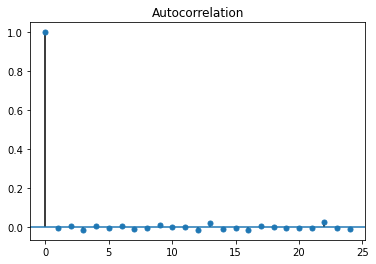

In [12]:
pm.plot_acf(stepwise_fit.resid())

#### 1.7 Make and evaluate forecasts using `RMSE` and `MAE`.

In [13]:
prediction = stepwise_fit.predict(n_periods = 20)

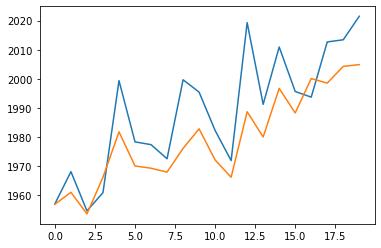

In [14]:
plt.plot(test, label = "Test")
plt.plot(prediction, label = "Predicted")
plt.show()

In [15]:
em.rmse(test, prediction)

12.864228655335037

In [16]:
em.meanabs(test, prediction)

10.687242202643494

***

## Step 2
Apply ARIMA models to all series, make and evaluate forecasts.

In [17]:
# forecast horizon
nfs = 20

# empty array to store forecasted values
pred_vals = np.zeros([num_series, nfs])
# empty array to store test values
test_vals = np.zeros([num_series, nfs])

In [18]:
for i, series in enumerate(ts):
    
    if i % 10 == 0:
        print(i, 'out of', num_series, 'models trained.')
    
    # split into training and testing data
    train, test = series[:-nfs], series[-nfs:]
    
    # store test data
    test_vals[i,:] = test
    
    # calculate the number of differences
    d = pm.arima.ndiffs(train, alpha = 0.05, test = 'kpss', max_d = 2)
    
    # calculate the number of seasonal differences
    D = pm.arima.nsdiffs(train, m, max_D = 2, test = 'ocsb')
    
    # fit stepwise auto-ARIMA
    stepwise_fit = pm.auto_arima(train, 
                                 m=m,                    # seasonal differencing term                
                                 seasonal=True,          # compute seasonal model
                                 d=d,                    # pre-calculated number of differences
                                 D=D,                    # pre-calculated number of seasonal differences
                                 trace=False,            # don't print optimization process results
                                 error_action='ignore',  # don't want to know if an order does not work
                                 suppress_warnings=True, # don't want convergence warnings
                                 stepwise=True)          # set to stepwise
    
    # make predictions for 20 period horizon
    prediction = stepwise_fit.predict(n_periods = nfs)
    
    # store predictions
    pred_vals[i,:] = prediction

0 out of 3 models trained.
1 out of 3 models trained.
2 out of 3 models trained.


In [19]:
# calculate root mean squared error and mean absolute error
# for predictions from all series

# empty arrays for errors
rmse = np.zeros(num_series)
mae = np.zeros(num_series)

for i in range(num_series):
    rmse[i] = em.rmse(test_vals[i,:], pred_vals[i,:])
    mae[i] = em.meanabs(test_vals[i,:], pred_vals[i,:])

In [20]:
# average root mean squared error across series
np.mean(rmse)

73.07399693716287

In [21]:
# average mean absolute error across series
np.mean(mae)

64.51640545968327

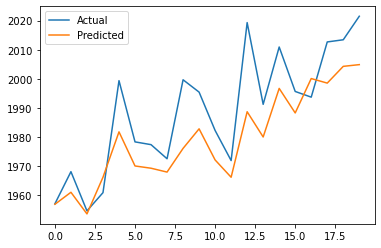

In [22]:
plt.plot(test_vals[0,:], label = "Actual")
plt.plot(pred_vals[0,:], label = "Predicted")
plt.legend()
plt.show()

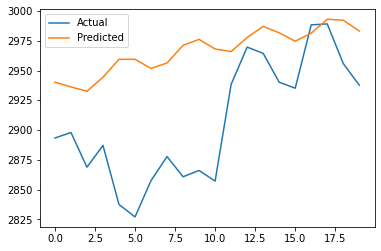

In [23]:
plt.plot(test_vals[1,:], label = "Actual")
plt.plot(pred_vals[1,:], label = "Predicted")
plt.legend()
plt.show()

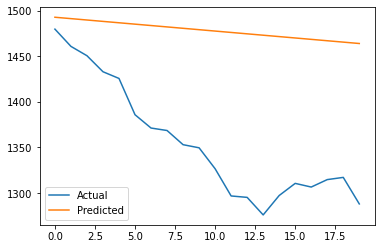

In [24]:
plt.plot(test_vals[2,:], label = "Actual")
plt.plot(pred_vals[2,:], label = "Predicted")
plt.legend()
plt.show()